<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоги</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install nltk

In [2]:
import ssl
import nltk

In [3]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgeniu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/evgeniu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/evgeniu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/evgeniu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
import pandas as pd
import os
import re
import nltk

import numpy as np

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import lightgbm as lgbm

RND_SEED = 12345

## Подготовка

In [5]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0], index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0], index_col=0)
else:
    print('Датасет не найден')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


С названиями колонок, типом данных все хорошо. Пропусков нет.

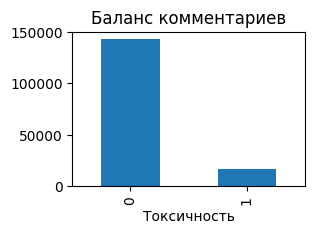

In [7]:
data.toxic.value_counts().plot(kind='bar', title='Баланс комментариев', xlabel='Токсичность', figsize=(3,2));

Классы не сбалансированы. Нужно это учитывать в дальнейшей работе.

In [8]:
sum(data.duplicated())

0

Дубликатов нет.

### Преобразование текста

Напишем методы и преобразуем текст.

* clear_text - очищает текст от лишних символов, приводит текст в нижний регистр
* lemmatize - лемантизатор и токенизатор построенный на nltk
* drop_stopwords - функция удаления стопслов 

In [9]:
def clear_text(text):
    return ' '.join(re.sub(r'[^\'a-zA-Z ]', ' ', text.lower()).split())

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemm_text = " ".join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

    return lemm_text

stop_words = list(stopwords.words('english'))

def drop_stopwords(text):
    text = text.split()
    res = []
    for w in text:
        if w not in stop_words:
            res.append(w)
    return " ".join(res)

In [10]:
data['clear_text'] = data['text'].apply(clear_text)

In [11]:
data['clear_text'] = data['clear_text'].apply(lambda x: lemmatize(x))

In [12]:
#data['clear_text'] = data['clear_text'].apply(lambda x: drop_stopwords(x))

In [13]:
data.head(5)

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Данные стали попроще без потери смысла.

 ### Построение tf-idf модели

На очищенном тексте можно построить tf-idf матрицу

In [14]:
tf_idf = TfidfVectorizer(stop_words=stop_words)

In [15]:
X = data['clear_text']
y = data['toxic']

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.25, random_state=RND_SEED, stratify=y)

In [17]:
Xtrain = tf_idf.fit_transform(Xtrain)
Xtest = tf_idf.transform(Xtest)

In [18]:
Xtrain.shape, Xtest.shape

((119469, 128036), (39823, 128036))

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно. Отлично, что векторизатор был обучен только на тренировочной части данных.
</div>

## Обучение

### Решающее дерево

In [19]:
def decision_tree():
    dt_model = DecisionTreeClassifier(random_state=RND_SEED, class_weight='balanced')
    params = {
        'max_depth': range(100, 180, 20),
        'max_leaf_nodes':range(150, 301, 50)
    }
    tree_gs = HalvingGridSearchCV(estimator=dt_model,
                                  param_grid=params, scoring='f1',
                                  factor=5, cv=5, n_jobs=-1, verbose=0)
    tree_gs.fit(Xtrain, ytrain)
    return 'Решающее дерево', tree_gs

In [20]:
dt_solvers = decision_tree()

In [21]:
print(f'Модель {dt_solvers[0]} F1 score {dt_solvers[1].best_score_}')

Модель Решающее дерево F1 score 0.5957271507122448


### Логистическая регрессия

In [22]:
def logistic_regression():    
    lr_model = LogisticRegression(n_jobs=-1, max_iter=5000, solver='lbfgs', penalty='l2', class_weight='balanced')
    params = {'C' : np.arange(.1, .7, .1)}
    log_rs = HalvingGridSearchCV(estimator=lr_model,
                                        param_grid=params, scoring='f1',
                                        factor=5, cv=5, n_jobs=-1, verbose=0)
    log_rs.fit(Xtrain, ytrain)
    return 'Логистическая регрессия', log_rs

In [23]:
log_solver = logistic_regression()

In [24]:
print(f'Модель {log_solver[0]} F1 score {log_solver[1].best_score_}')

Модель Логистическая регрессия F1 score 0.7365161794266823


### LGBMClassifier

In [25]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1) 
    return 'f1', f1_score(y_true, y_hat), True

In [26]:
train_dataset = lgbm.Dataset(Xtrain, ytrain)
test_dataset = lgbm.Dataset(Xtest, ytest)

cv_output = lgbm.cv({"objective": "binary", "verbosity": -1},
                   train_set=train_dataset, num_boost_round=800,
                   feval=lgb_f1_score,
                   folds=StratifiedShuffleSplit(n_splits=3),
                   verbose_eval=False,
                   return_cvbooster=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [27]:

print('Модель LGBM F1 score', cv_output['f1-mean'][-1])

Модель LGBM F1 score 0.7706064041473276


## Итоги

Мы подготовили данные и обучили несколько моделей для определения токсичного текста. F1 результаты обучения на кроссвалидации:

* Модель Решающее дерево F1 score 0.5957
* Модель Логистическая регрессия F1 score 0.7365
* Модель LGBM F1 score 0.7706

Самый сильный результат получился на модели градиентного бустинга. Проверим его на тестовой выборке:

In [29]:
print('Модель LGBM F1 score на тестовой выборке:', 
      f1_score(ytest, np.where(lgbm_model.boosters[2].predict(Xtest) < 0.5, 0, 1)))

Модель LGBM F1 score на тестовой выборке: 0.7763898421413865


Модель соответствует требованиям проекта. Работу можно считать завершенной.